# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 7
### <center> Yoshihiro Shirai

# Support Vector Machines, Part 2

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 5: SVMs in Scikit-Learn, nonlinear and kernelized SVMs. SVMs for regression.

#  0. Overview of the lecture

- We continue our discussion of SVMs. We start by discussing how linear SV classifiers are implemented in Scikit-learn.

- We then show how to use linear SVM classifiers on data sets that are not linearly separable through adding features.

- Then we discuss the kernel trick which simplifies adding features to linearize a nonlinear data set.

- We briefly outside how to use SVMs for regression.

# 1. Linear SV classification in Scikit-learn

- The following three classes in Scikit-learn implement linear SV classifiers:

    -`sklearn.svm.LinearSVC`: This is a QP based implementation. **Fastest** among the three method and **scales linearly** with the sample size. However, one cannot implement the kernel trick (to be discussed later).

    - `sklearn.linear_model.SGDClassifier`: Uses the SGD on the unconstrained formulation of soft margin SV classifier. Slower than QP based algorithms. However, can be used for <strong>online and out-of-core learning</strong>. Also, implements the <strong>early stopping</strong> strategy for regularizing models. </li>

    - <code>sklearn.svm.SVC</code>: Another QP based implementation. Slower than <code>LinearSVC</code>. Supports the <strong>kernel trick</strong>

- Let us illustrate linear SV classifiers using the iris data set.

- SV classifiers are binary classifiers. So, let us start by detecting Iris-Virginica.

In [5]:
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

- As we mentioned before, it is crucial for SV classifiers that the features are standardized. Let us create a pipeline to feed the features to a linear SV classifiers.

In [6]:
from sklearn.pipeline import Pipeline # the purpose of pipeline is to sequentially combine the scaling transformation and the linear SV (more on this later)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
svm_clf_lsvc = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(loss="hinge", random_state=42))
    ])

- We can now train the <code>LinearSVC</code> classifier. Note that you can use the method <code>.set_params()</code> of pipelines to pass a parameter to a specific step. You can refer to the parameter by the name of the step, then "__" (two underscores), and then the name of the parameter. For example, we can pass <code>C=</code> to the LinearSVC classifier as follows.

In [7]:
svm_clf_lsvc.set_params(linear_svc__C=1).fit(X, y)
svm_clf_lsvc.predict([[5.5, 1.45]])

array([0.])

- Let us change the value of <code>C</code>.

In [8]:
svm_clf_lsvc.set_params(linear_svc__C=100).fit(X, y)

c:\Users\yoshi\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

<ul>
<li>It seems that we need to increase the maximum number of iteration in the underlying solver. We increase the argument <code>max_iter</code> from its default value until we don't get the warning. In this case, changing to 2000 will do.</li>
</ul>

In [9]:
svm_clf_lsvc.set_params(linear_svc__C=100,
                        linear_svc__max_iter=2000).fit(X, y)
svm_clf_lsvc.predict([[5.5, 1.45]])

array([1.])

<li>We can use the <code>SGDClassifier</code> class to fit linear SV classifier as follows.</li>

In [10]:
from sklearn.linear_model import SGDClassifier

svm_clf_sgd = Pipeline([
        ("scaler", StandardScaler()),
        ("sgd", SGDClassifier(loss="hinge", random_state=42,
                              max_iter=1000, tol=1e-12)),
    ])


- The regularization parameter in the <code>SGDClassifier</code> class is <code>alpha</code>$=\frac{1}{N\times C}$.

In [11]:
N=X.shape[0]
svm_clf_sgd.set_params(sgd__alpha=1/(N*1)).fit(X, y)
svm_clf_sgd.predict([[5.5, 1.45]])


array([1.])

- To use <code>SVC</code> class for linear SVM classification, simply pass the argument <code>kernel="linear"</code>. You should however avoid using this classifier for <strong>linear SVM</strong>. The <code>LinearSVC</code> is faster.

In [12]:
from sklearn.svm import SVC
svm_clf_svc = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="linear")),
    ])

In [13]:
svm_clf_svc.set_params(svc__C=1).fit(X, y)
svm_clf_svc.predict([[5.5, 1.45]])

array([1.])

- Let us plot the margins along with the training set, and the new instance that was used to make the above predictions in blue.

In [14]:
import matplotlib as mlp
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [15]:
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

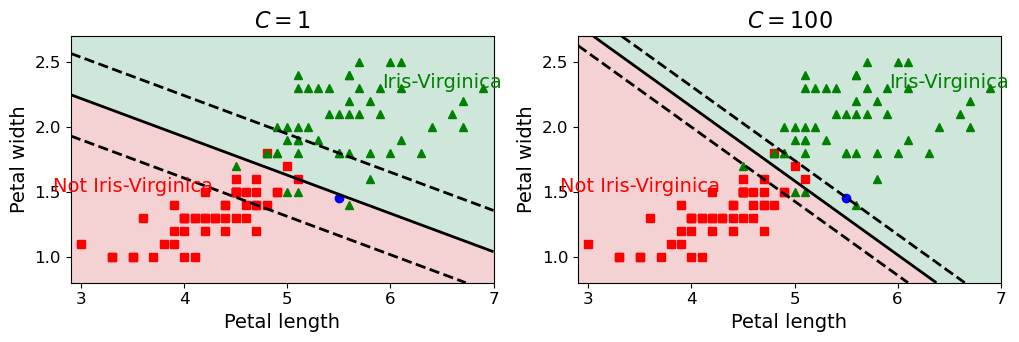

In [16]:
subplots=[121,122]
plt.figure(figsize=(12, 3.2))
for idx, C in enumerate([1,100]):
    svm_clf_lsvc.set_params(linear_svc__C=C).fit(X, y)
    decisionFn = svm_clf_lsvc.decision_function(X_new)
    zz = decisionFn.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[y==0, 0], X[y==0, 1], "rs")
    plt.plot(X[y==1, 0], X[y==1, 1], "g^")
    plt.plot(5.5, 1.45, "bo")
    plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="r", ha="center")
    plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
    plt.contour(x0, x1, zz, [-1,0,1], colors='k',
            linewidths=[2], linestyles=["dashed", "solid", "dashed"])
    y_pred = svm_clf_lsvc.predict(X_new).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.RdYlGn, alpha=0.2)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.title("$C = {}$".format(C), fontsize=16)
    plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

 ## 1.1 Linear SV multiclass classification

- Next, let us consider multiclass classification. There is no need to define new instances of the classifier, we simply pass on multiclass labels.

-  `LinearSVC` implements OvR as the default. Since this class scales linearly with the sample size, there is no need for OvO.

- The `SVC` class implements OvO since it doesn't scale well with the sample size.

- The `SGDClassifier` class implements OvR.

- Refer to Chapter 2 of the textbook for more details about implementing OvR and OvO.

In [17]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
svm_clf_lsvc.set_params(linear_svc__C=1,
                        linear_svc__max_iter=50000).fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=1, loss='hinge', max_iter=50000,
                           random_state=42))])

In [18]:
svm_clf_lsvc.predict([[5.5, 1.45]])

array([2])

In [19]:
svm_clf_lsvc.decision_function([[5.5, 1.45]])

array([[-3.07402493, -0.97431928, -0.10012591]])

- Let us plot the decision boundaries for different values of the regularization parameter `C`.

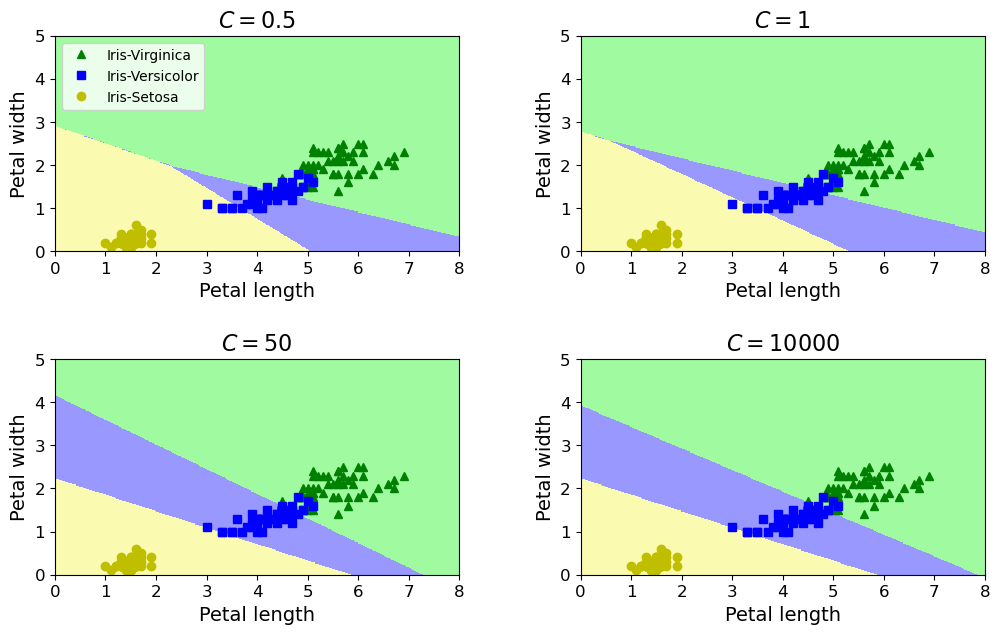

In [20]:
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

subplots=[221,222,223,224]
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
justonce = True
for idx, C in enumerate([0.5, 1, 50, 10000]):
    svm_clf_lsvc.set_params(linear_svc__C=C,
                            linear_svc__max_iter=500000).fit(X, y)
    y_df = svm_clf_lsvc.decision_function(X_new)
    y_predict = svm_clf_lsvc.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
    plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
    plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    if justonce:
        plt.legend(loc="upper left", fontsize=10)
        justonce=False
    plt.title("$C = {}$".format(C), fontsize=16)
    plt.axis([0, 8, 0, 5])
plt.show()

- As you can see, we cannot get a good decision boundary. The problem is that the boundaries are linear.

#  2. Nonlinear SV 

- To motivate the need for nonlinear SV classification, let us consider another dataset that is not linearly separable.

- Here, we use the make_moons function that generates a random sample of coordinates from two interleaving half circles.

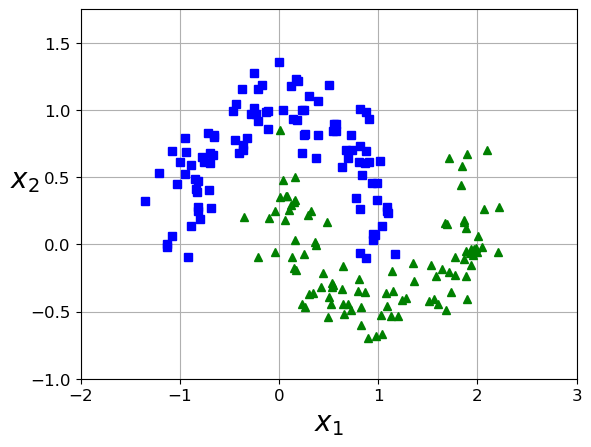

In [21]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.15, random_state=42)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.grid(True, which='both')
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.axis([-2, 3, -1, 1.75])
plt.show()

- Linear boundaries are not going to work no matter how much regularization we use.

- We have to come up with an alternative approach that allows for non-linear decision boundaries.

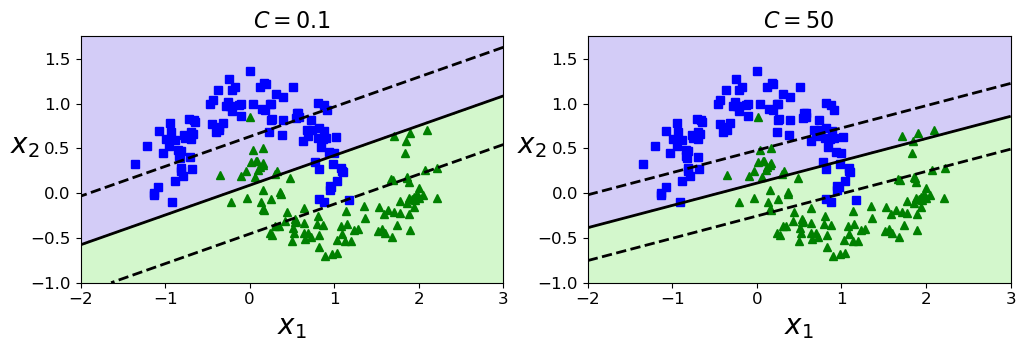

In [22]:
x0, x1 = np.meshgrid(np.linspace(-2, 3, 200).reshape(-1, 1),
                     np.linspace(-1, 1.75, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

subplots=[121,122]
plt.figure(figsize=(12, 3.2))
for idx, C in enumerate([0.1,50]):
    svm_clf_lsvc.set_params(linear_svc__C=C,
                            linear_svc__max_iter=5000).fit(X, y)
    decisionFn = svm_clf_lsvc.decision_function(X_new)
    zz = decisionFn.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.contour(x0, x1, zz, [-1,0,1], colors='k',
            linewidths=[2], linestyles=["dashed", "solid", "dashed"])
    y_pred = svm_clf_lsvc.predict(X_new).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.title("$C = {}$".format(C), fontsize=16)
    plt.axis([-2, 3, -1, 1.75])
plt.show()

- As we have seen, many data sets are far from linearly separable. However, this does not mean that you cannot use a linear model (such as linear SVM) to fit them.

- We have seen how to use linear models to fit nonlinear relationships. Polynomial regression is an example.

- The trick is to add more features. If we properly "**map**" a nonlinear data set to a higher dimensional space, it will become linearly separable. See the following example.

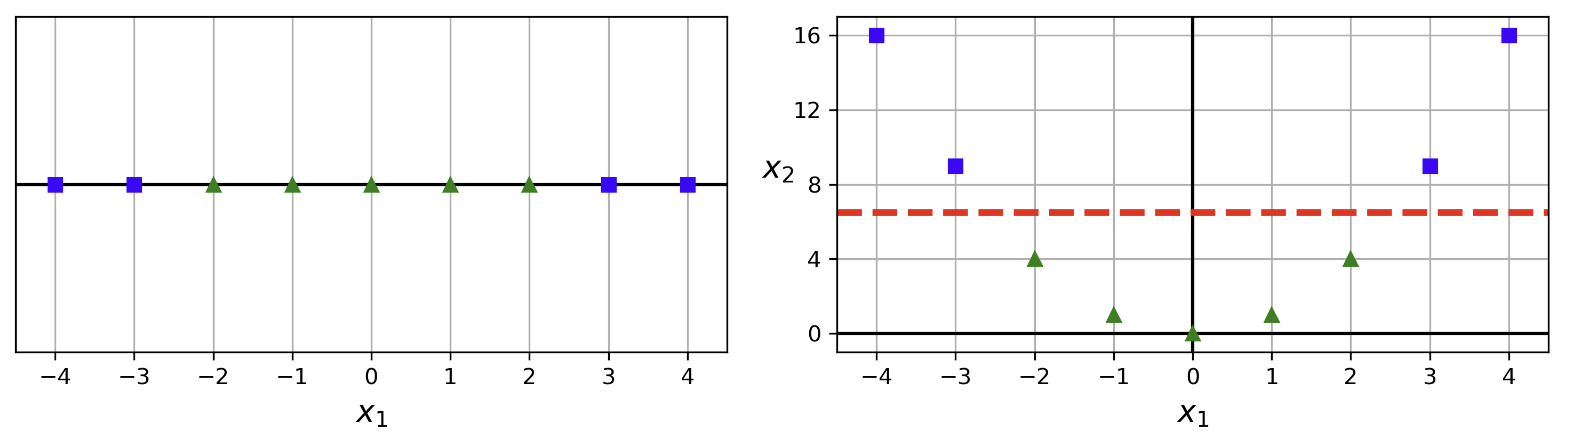

In [23]:
from IPython.display import Image
Image("Figs/higher_dimensions_plot.png",width=800)

- Let us apply this trick to the make_moons dataset.

- We can automatically add polynomial features by the `sklearn.preprocessing.PolynomialFeatures` class

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly_feature = PolynomialFeatures(degree=2)

In [25]:
X[:2]

array([[-1.07816119,  0.06336772],
       [ 0.93980859,  0.4571195 ]])

In [26]:
poly_feature.fit_transform(X[:2])

array([[ 1.        , -1.07816119,  0.06336772,  1.16243156, -0.06832062,
         0.00401547],
       [ 1.        ,  0.93980859,  0.4571195 ,  0.88324019,  0.42960483,
         0.20895824]])

- Let us define a new pipeline that adds polynomial features, standardizes the features, and then applies a linear SV classifier.

In [27]:
poly_linsvc = Pipeline([
        ("poly", PolynomialFeatures()),
        ("scaler", StandardScaler()),
        ("linsvc", LinearSVC(loss="hinge", random_state=42))
    ])

- We can fit the model as follows.

In [28]:
poly_linsvc.set_params(poly__degree=3,
                       linsvc__C=1,
                       linsvc__max_iter=5000).fit(X, y)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('linsvc',
                 LinearSVC(C=1, loss='hinge', max_iter=5000, random_state=42))])

- We can use ``.predict()`` and ``.decision_function()`` to predict the label for new values of the features and the corresponding value of the decision function. 

- Note that you can pass on the original coordinates, as the pipeline takes care of the transformation (which is why we use the pipeline).

In [29]:
poly_linsvc.predict([[0,0]])

array([1], dtype=int64)

In [30]:
poly_linsvc.decision_function([[0,0]])

array([1.34209672])

- Let us see how the decision boundaries look like.

- They are nonlinear and we can find different shapes. We can now easily overfit the training set (simply use a high degree polynomial and high value of `C`).

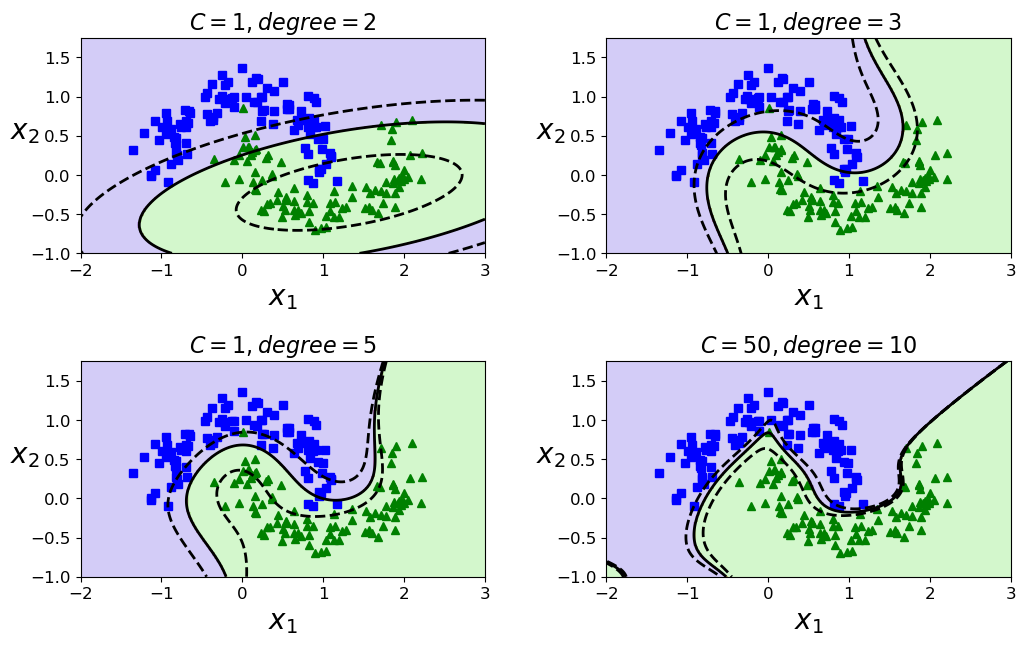

In [31]:
subplots=[221,222,223,224]
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, param in enumerate([(1,2),(1,3), (1,5),(50,10)]):
    C, degree = param
    poly_linsvc.set_params(poly__degree=degree,
                           linsvc__C=C,
                           linsvc__max_iter=50000).fit(X, y)
    decisionFn = poly_linsvc.decision_function(X_new)
    zz = decisionFn.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.contour(x0, x1, zz, [-1,0,1], colors='k',
            linewidths=[2], linestyles=["dashed", "solid", "dashed"])
    y_pred = poly_linsvc.predict(X_new).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.title("$C = {}, degree = {}$".format(C,degree), fontsize=16)
    plt.axis([-2, 3, -1, 1.75])
plt.show()

- Of course, overfitting the training set is not the goal. The point here is that the model is not as inflexible as before when the decision boundaries were lines.

- It is possible to use learning curves and grid search with cross validation to find values of the hyperparameters `degree` and `C` that yields a good bias/variance tradeoff.

- From the previous plots, it appears `degree=3` is the best fit. We can plot the fit for degree=3 and various values of `C`.

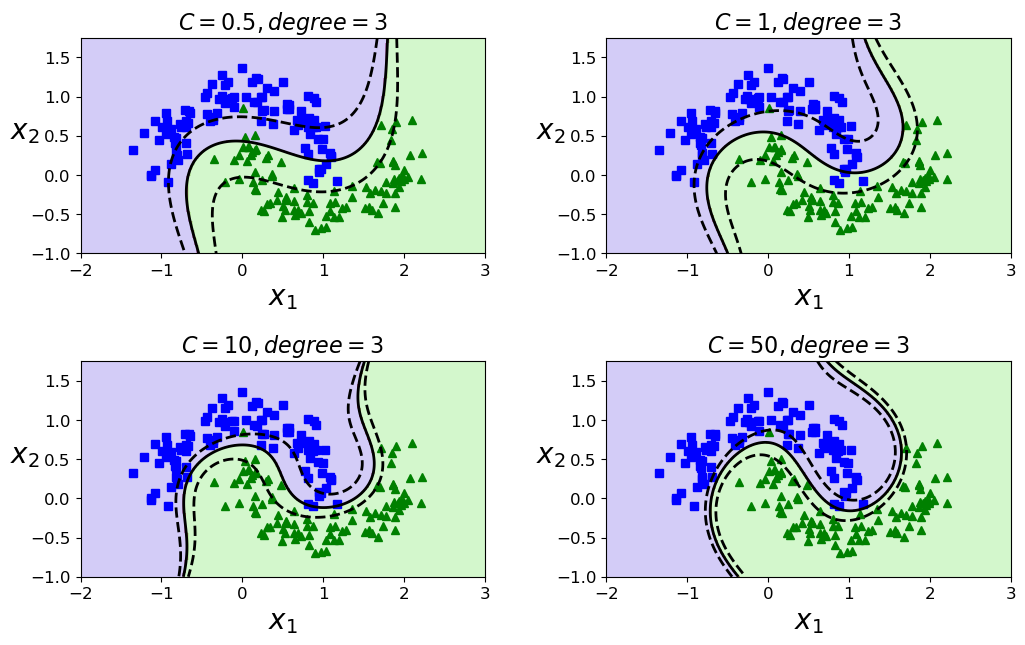

In [32]:
subplots=[221,222,223,224]
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, param in enumerate([(0.5,3),(1,3), (10,3),(50,3)]):
    C, degree = param
    poly_linsvc.set_params(poly__degree=degree,
                           linsvc__C=C,
                           linsvc__max_iter=50000).fit(X, y)
    decisionFn = poly_linsvc.decision_function(X_new)
    zz = decisionFn.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.contour(x0, x1, zz, [-1,0,1], colors='k',
            linewidths=[2], linestyles=["dashed", "solid", "dashed"])
    y_pred = poly_linsvc.predict(X_new).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.title("$C = {}, degree = {}$".format(C,degree), fontsize=16)
    plt.axis([-2, 3, -1, 1.75])

## 2.1 Nonlinear SV multiclass classification

- Let us see if we can find better decision boundaries in the multiclass classification of the Iris data set.

In [33]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

- The boundaries are not linear anymore.

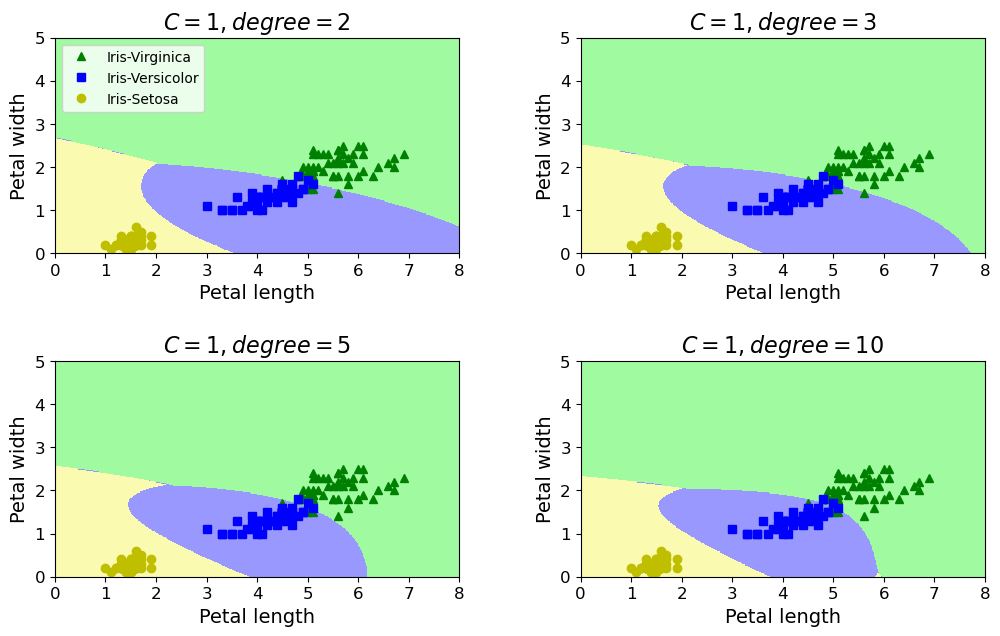

In [34]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

subplots=[221,222,223,224]
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
justonce = True
for idx, param in enumerate([(1,2),(1,3), (1,5),(1,10)]):
    C, degree = param
    poly_linsvc.set_params(poly__degree=degree,
                           linsvc__C=C,
                           linsvc__max_iter=50000).fit(X, y)
    y_predict = poly_linsvc.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
    plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
    plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    if justonce:
        plt.legend(loc="upper left", fontsize=10)
        justonce=False
    plt.title("$C = {}, degree = {}$".format(C,degree), fontsize=16)
    plt.axis([0, 8, 0, 5])
plt.show()

- We should be able to find a good model by choosing suitable values of the hyperparameters.

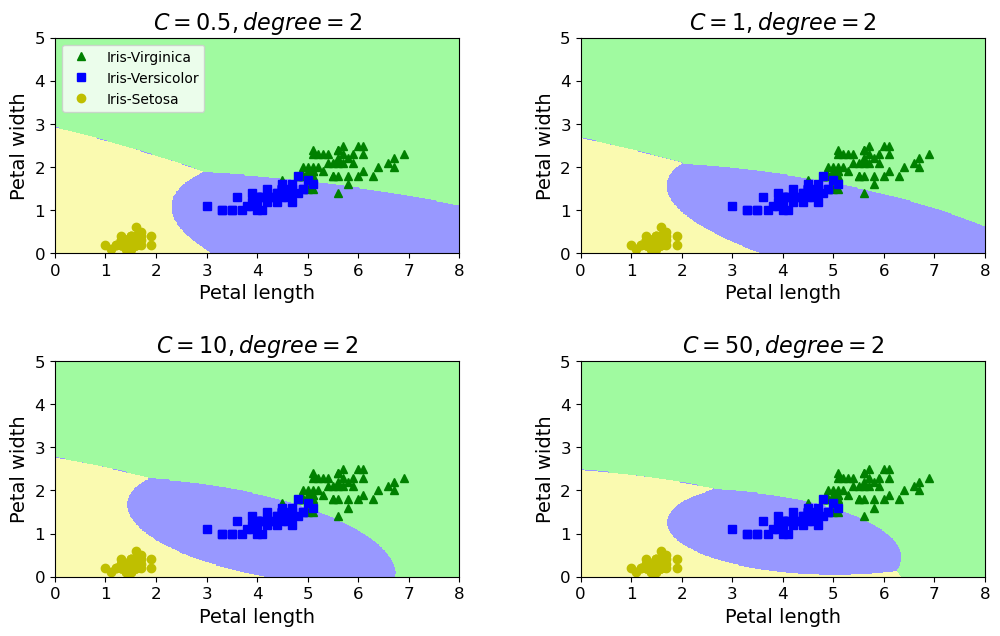

In [35]:
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
justonce = True
for idx, param in enumerate([(0.5,2),(1,2), (10,2),(50,2)]):
    C, degree = param
    poly_linsvc.set_params(poly__degree=degree,
                           linsvc__C=C,
                           linsvc__max_iter=50000).fit(X, y)
    y_predict = poly_linsvc.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
    plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
    plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")
    plt.contourf(x0, x1, zz, cmap=custom_cmap)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    if justonce:
        plt.legend(loc="upper left", fontsize=10)
        justonce=False
    plt.title("$C = {}, degree = {}$".format(C,degree), fontsize=16)
    plt.axis([0, 8, 0, 5])
plt.show()


- There are other approaches to add features to linearize a nonlinear data set.

- One approach is to add **similarity features** instead of polynomial features.

- Consider the example below where we have a nonlinear data set. We define two **landmarks** and add the distances from these two landmarks as two new features for every observation. Instead of using the actual distance however, we use the **Gaussian Radial Basis Function** (or, **Gaussian RBF**)
$$\begin{align*}
    \varphi_{\gamma}(\mathbf{x}, \mathbf{\ell}) = e^{-\gamma\|\mathbf{x}-\mathbf{\ell}\|^2}.
\end{align*}$$

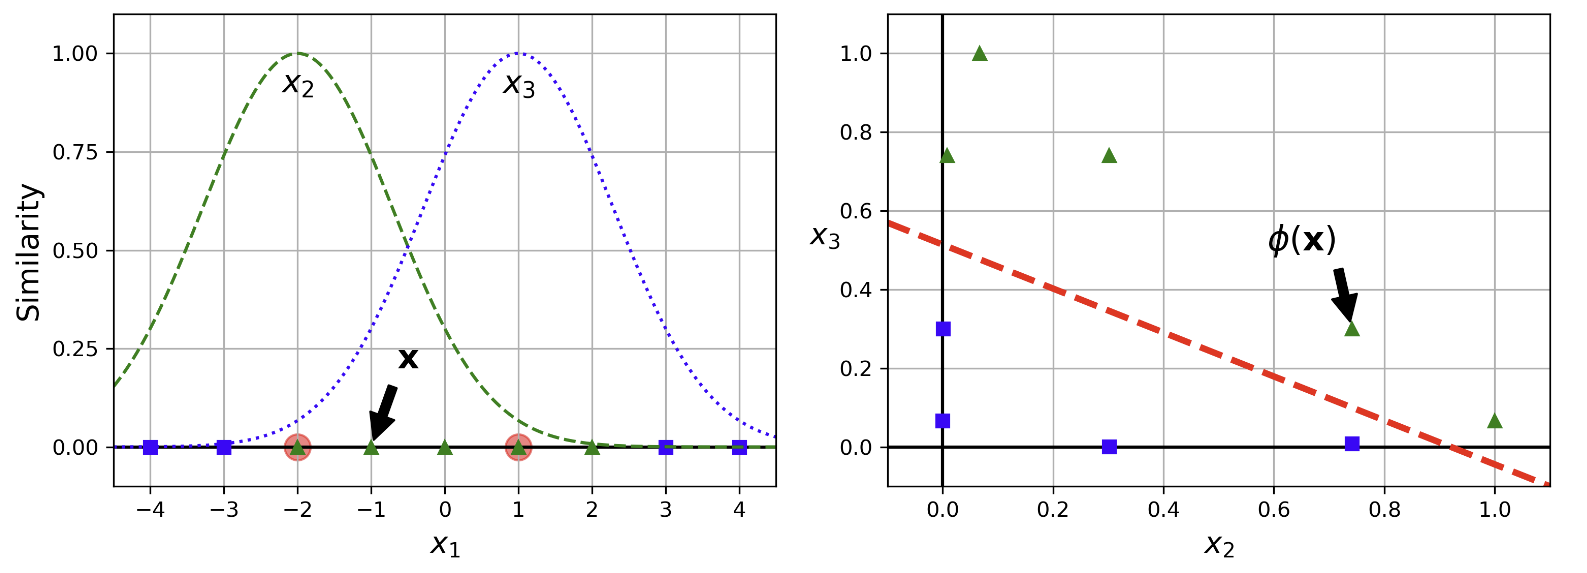

In [36]:
Image("Figs/kernel_method_plot.png",width=800)

- So how should we choose the landmarks?

- One approach is to take a landmark at every observation and then let the model decide which landmark is important (we can regularize the parameters by the $\ell_1$ norm).

- This way, there is a high chance that the transformed data set becomes linearly separable.

- The disadvantage of this approach is that you end up adding as many features as the sample size. This can slow down training the model, doing grid search etc.

- Fortunately, there is a way around this problem. The kernel trick allows you to fit a SVM as if you added features without actually adding them, with the Gaussian RBF kernel giving a similar result as if adding many similarity features.

# 3. Kernelized SVM

- Mathematically, adding features is applying a function $\Phi(\cdot)$ that assigns to each feature vector $\mathbf{x}_n$ a higher dimensional feature vector $\Phi(\mathbf{x}_n)$

- For example, consider adding 2nd degree polynomial features, where a feature vector $\mathbf{x}_n=(1, x_{n,1},x_{n,2})$ is mapped to a higher dimensional feature vector
$$\begin{align*}
  \mathbf{x}_n' = (1, x_{n,1}^2, x_{n,2}^2, \sqrt{2}\,x_{n,1}, \sqrt{2}\,x_{n,2}, \sqrt{2}\,x_{n,1}x_{n,2}).
\end{align*}$$

- In this case, $\Phi:\mathbb{R}^3\to\mathbb{R}^6$ and is given by
$$\begin{align*}
  \Phi(a_1,a_2,a_3) = (a_1^2, a_2^2, a_3^2, \sqrt{2}\,a_1 a_2, \sqrt{2}\,a_1 a_3, \sqrt{2}\,a_2 a_3).
\end{align*}$$

- Consider the Linear SVM classification problem when we added features using the function $\Phi: \mathbb{R}^K\to\mathbb{R}^L$, where $L >K$,
$$\begin{align*}
    &\min_{\mathbf{w},b,\zeta_1,\dots,\zeta_N} \frac{1}{2}\mathbf{w}^\top\mathbf{w} + C \sum_{n=1}^N \zeta_n\\
    &\text{subject to:}\\
    &y_n(\mathbf{w}\cdot \Phi(\mathbf{x}_n) + b) + \zeta_n \ge 1; \quad\quad n\in\{1,\dots,N\},\\
    &\zeta_n \ge 0; \quad\quad n\in\{1,\dots,N\}.
\end{align*}$$

- Note that we have $L$ feature weights $\mathbf{w}=(w_1,\dots,w_L)$. So, after adding features, the primal form of the QP is harder to solve than the one using the original features.

- Next, consider the dual formulation:
$$\begin{align*}
    &\max_{\lambda_1,\dots,\lambda_N} \sum_{n=1}^N \lambda_n -\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \lambda_i\lambda_j y_i y_j \big(\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_j)\big)\\
    &\text{subject to:}\\
    &0\le \lambda_n \le C; \quad\quad n\in\{1,\dots,N\}.
\end{align*}$$

- The dual problem has the same number of variables $\lambda_1,\dots,\lambda_N$ as before adding new features. Furthermore, the only change is that $\mathbf{x}_i\cdot\mathbf{x}_j$ is replaced by $\Phi(\mathbf{x}_i)\cdot\Phi(\mathbf{x}_j)$.

- For the 2nd degree polynomial features, we have
$$\begin{align*}
    \Phi(\mathbf{a})\cdot\Phi(\mathbf{b}) = \begin{pmatrix}a_1^2\\ a_2^2\\ a_3^2\\ \sqrt{2}\,a_1 a_2\\ \sqrt{2}\,a_1 a_3\\ \sqrt{2}\,a_2 a_3\end{pmatrix}\cdot \begin{pmatrix}b_1^2\\ b_2^2\\ b_3^2\\ \sqrt{2}\,b_1 b_2\\ \sqrt{2}\,b_1 b_3\\ \sqrt{2}\,b_2 b_3\end{pmatrix}=(\mathbf{a}\cdot\mathbf{b})^2.
\end{align*}$$

- This relationship for polynomial features is not an exception. There are many functions $K(\mathbf{a},\mathbf{b})$ that satisfy the relationship
$$K(\mathbf{a},\mathbf{b})=\Phi(\mathbf{a})\cdot\Phi(\mathbf{b})$$

- Here, $\Phi(\cdot)$ is a function that maps $\mathbb{R}^K$ to a possibly higher dimensional space (even infinite dimensional space).

- Such functions $K(\cdot,\cdot)$ are called <strong>kernels</strong>. They help you <strong>evaluate the inner product $\Phi(\mathbf{a})\cdot\Phi(\mathbf{b})$ without using the mapping $\Phi$</strong> (or even knowing what it is).

- According to a theorem from functional analysis, called <strong>Mercer's Theorem</strong>, any function $K$ that satisfies the following conditions (known as Mercer's conditions) is a kernel</p>
    - $K$ is continuous
    - $K$ is symmetric: $K(\mathbf{a},\mathbf{a})=K(\mathbf{b},\mathbf{a})$
    - $K$ is positive semidefinite: $\sum_{i=1}^n\sum_{j=1}^n K(\mathbf{a}_i,\mathbf{b}_j)c_i c_j\ge0$, for any choice of $n$, $\mathbf{a}_i$, $\mathbf{b}_i$, $c_i$, $i\in\{1,\dots,n\}$.

- In other words, if $K$ satisfies these conditions, there is a mapping $\Phi$ such that $K(\mathbf{a},\mathbf{b}) = \Phi(\mathbf{a})\cdot\Phi(\mathbf{b})$

- Assume that you are adding features according to a mapping $\Phi$, and that $K(\mathbf{a},\mathbf{b}) = \Phi(\mathbf{a})\cdot\Phi(\mathbf{b})$

- Then the dual formulation of SVM classifier becomes
$$\begin{align*}
    &\max_{\lambda_1,\dots,\lambda_N} \sum_{n=1}^N \lambda_n -\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N \lambda_i\lambda_j y_i y_j K(\mathbf{x}_i,\mathbf{x}_j)\\
    &\text{subject to:}\\
    &0\le \lambda_n \leq C; \quad\quad n\in\{1,\dots,N\}.
\end{align*}$$

- Note that we don't need to know what $\Phi$ is! We can simply apply the kernel to the original features and solve the dual problem <strong>as if we have considered adding the extra features.

- We still have a problem though, how can we find the decision function?

- From the previous lecture, the decision function is
$$\begin{align*}
    s(\mathbf{x}) = \hat{\mathbf{w}} \cdot \Phi(\mathbf{x}) + \hat{h}
\end{align*}$$

- The feature weights $\hat{\mathbf{w}}$ corresponds to the new features $\Phi(\mathbf{x})$. What to do here?

- The kernel trick helps us again. Recall that from the previous lecture:
$$\begin{align*}
    \hat{\mathbf{w}} = \sum_{n=1}^N \lambda_n^* y_n \Phi(\mathbf{x}_n).
\end{align*}$$

- Therefore,
$$\begin{align*}
    s(\mathbf{x}) &= \hat{\mathbf{w}}\cdot \Phi(\mathbf{x}) + \hat{b}\\
    &=\sum_{n=1}^N \lambda_n^* y_n \Phi(\mathbf{x}_n)\cdot\Phi(\mathbf{x}) + \hat{b}\\
    &=\sum_{n=1}^N \lambda_n^* y_n K(\mathbf{x}_n,\mathbf{x}) + \hat{b}
\end{align*}
$$

- We can also use the kernel trick to find $\hat{b}$ as follows:
$$\begin{align*}
    \hat{b}&= \frac{1}{N_s} \sum_{n:\lambda^*>0}\left[y_n - \hat{\mathbf{w}}\cdot\Phi(\mathbf{x}_n)\right]\\
    &= \frac{1}{N_s} \sum_{n:\lambda^*_n>0}\left[y_n - \left(\sum_{j=1}^N \lambda_j^* y_j \Phi(\mathbf{x}_j)\right)\cdot\Phi(\mathbf{x}_n)\right]\\
    &= \frac{1}{N_s} \sum_{n:\lambda^*_n>0}\left[y_n - \sum_{j: \lambda^*_j>0} \lambda_j^* y_j K(\mathbf{x}_j,\mathbf{x}_n)\right].
\end{align*}$$

- Putting everything together, we find the following form for the decision function
$$\begin{align*}
    s(\mathbf{x}) =\sum_{n=1}^N \lambda_n^* y_n K(\mathbf{x}_n,\mathbf{x}) + \frac{1}{N_s} \sum_{n:\lambda^*>0}\left[y_n - \sum_{j: \lambda^*>0} \lambda_j^* y_j K(\mathbf{x}_j,\mathbf{x}_n)\right].
\end{align*}$$

- We only need to solve the dual problem to find $\lambda_1^*,\dots,\lambda_N^*$. Then, we know the decision function.

- The main point here is that we need to know the kernel function $K(\mathbf{a},\mathbf{b})$ and not the mapping $\Phi$.

- Common kernels are:
$$\begin{align*}
    \text{Linear: } &\quad K(\mathbf{a},\mathbf{b}) = \mathbf{a}\cdot\mathbf{b}\\
    \text{Polynomial: } &\quad K(\mathbf{a},\mathbf{b}) = (\gamma \mathbf{a}\cdot\mathbf{b} + r)^d\\
    \text{Gaussian RBF: } &\quad K(\mathbf{a},\mathbf{b}) = \exp\left(-\gamma\|\mathbf{a}-\mathbf{b}\|^2\right)\\
    \text{Sigmoid: } &\quad K(\mathbf{a},\mathbf{b}) = \tanh(\gamma\,\mathbf{a}\cdot\mathbf{b} + r)
\end{align*}$$

- Some kernels, such as the Gaussian RBF corresponds to adding infinite number of new features (the kernel trick makes these types of mapping possible).

- Some others, such as the sigmoid kernel, do not satisfy Mercer's theorem, yet, they are useful in many applications.

- Let us illustrate kernelized SVM classifier using the make_moons dataset


In [37]:
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
x0, x1 = np.meshgrid(np.linspace(-2, 3, 200).reshape(-1, 1),
                     np.linspace(-1, 1.75, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

- We should use `SVC` class which implements the kernel trick

In [38]:
kernel_svc = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC())
    ])


- We can do polynomial kernel as follows. The results resembles what we got by adding polynomial features.

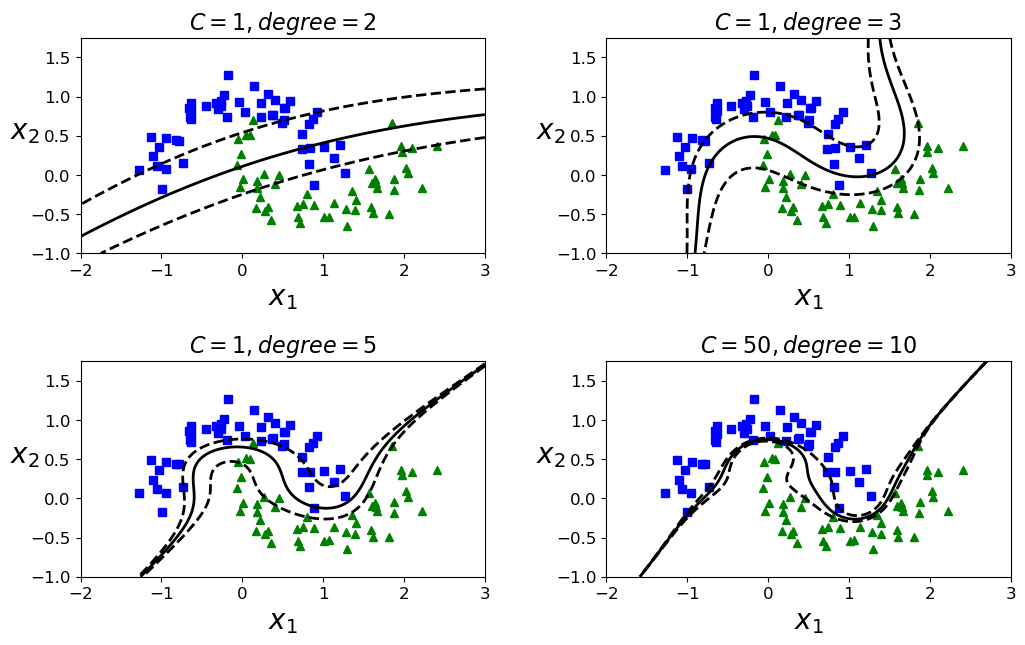

In [39]:
subplots=[221,222,223,224]
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, param in enumerate([(1,2),(1,3), (1,5),(50,10)]):
    C, degree = param
    kernel_svc.set_params(svc__kernel='poly',
                          svc__degree=degree,
                          svc__coef0=1,
                          svc__C=C).fit(X, y)
    decisionFn = kernel_svc.decision_function(X_new)
    zz = decisionFn.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.contour(x0, x1, zz, [-1,0,1], colors='k',
            linewidths=[2], linestyles=["dashed", "solid", "dashed"])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.title("$C = {}, degree = {}$".format(C,degree), fontsize=16)
    plt.axis([-2, 3, -1, 1.75])
plt.show()

- We can also use other kernels, say, Gaussian RBF. Note the effect of the hyperparameter `gamma`. It makes the decision boundary more "local", similar to the bandwidth in kernel density estimation.

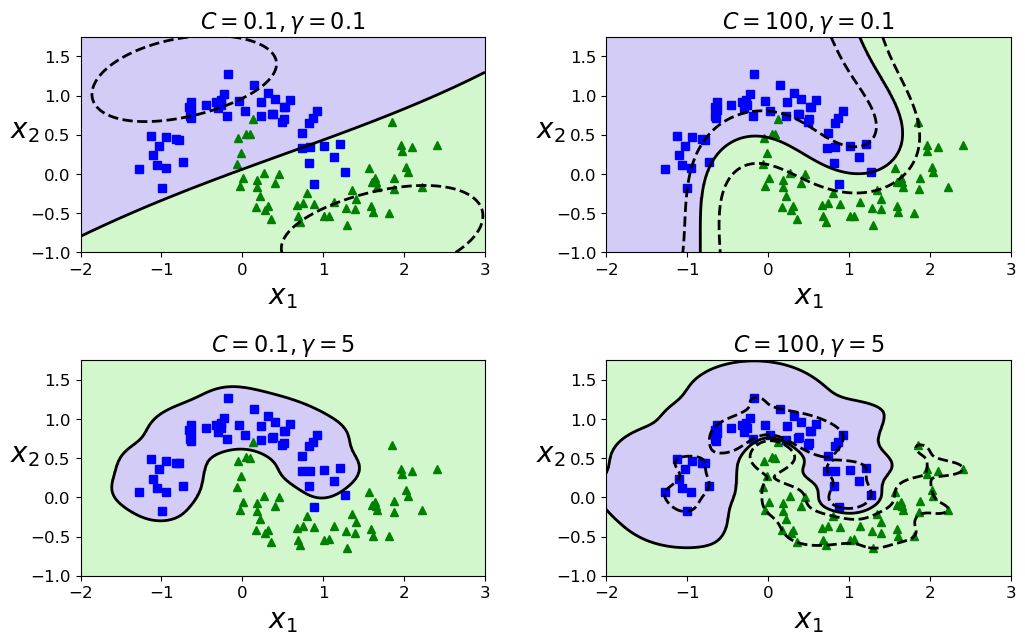

In [40]:
subplots=[221,222,223,224]
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, param in enumerate([(0.1,0.1),(100,0.1), (0.1,5),(100,5)]):
    C, gam = param
    kernel_svc.set_params(svc__kernel='rbf',
                          svc__gamma=gam,
                          svc__C=C).fit(X, y)
    decisionFn = kernel_svc.decision_function(X_new)
    zz = decisionFn.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.contour(x0, x1, zz, [-1,0,1], colors='k',
            linewidths=[2], linestyles=["dashed", "solid", "dashed"])
    y_pred = kernel_svc.predict(X_new).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.title("$C = {}, \gamma = {}$".format(C,gam), fontsize=16)
    plt.axis([-2, 3, -1, 1.75])
plt.show()

- We can also use other kernels, say, Gaussian RBF. 

- Note the effect of the hyperparameter gamma: 
    - it makes the decision boundary more "local"
    - it is similar to the bandwidth of a kernel density estimation.

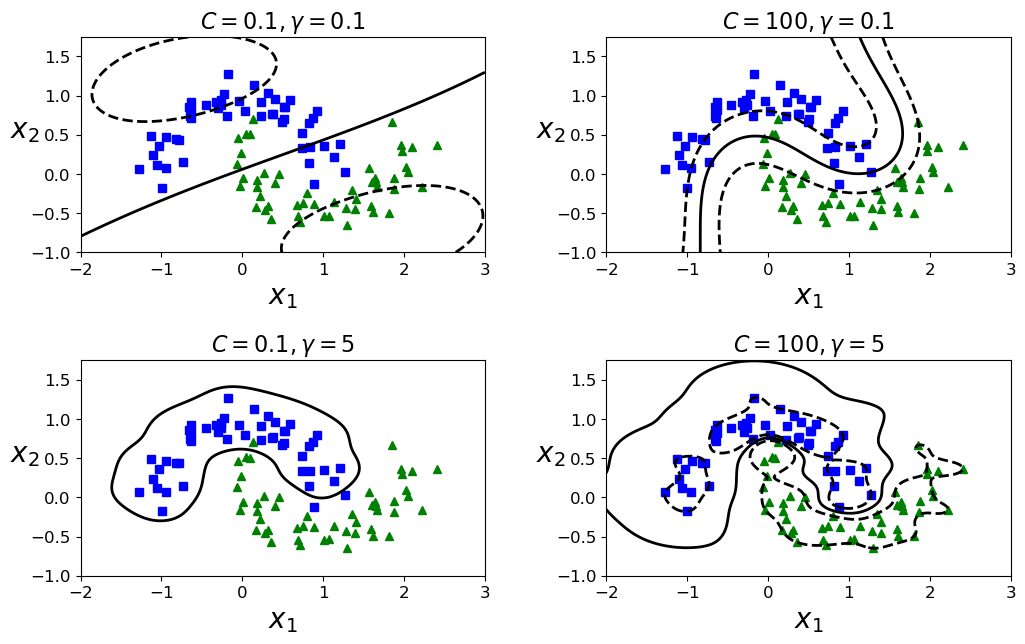

In [41]:
subplots=[221,222,223,224]
plt.figure(figsize=(12, 7))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for idx, param in enumerate([(0.1,0.1),(100,0.1), (0.1,5),(100,5)]):
    C, gam = param
    kernel_svc.set_params(svc__kernel='rbf',
                          svc__gamma=gam,
                          svc__C=C).fit(X, y)
    decisionFn = kernel_svc.decision_function(X_new)
    zz = decisionFn.reshape(x0.shape)
    plt.subplot(subplots[idx])
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.contour(x0, x1, zz, [-1,0,1], colors='k',
            linewidths=[2], linestyles=["dashed", "solid", "dashed"])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
    plt.title("$C = {}, \gamma = {}$".format(C,gam), fontsize=16)
    plt.axis([-2, 3, -1, 1.75])
plt.show()



# Linear and nonlinear SV Regression

- SVM is capable of linear and nonlinear regregression, not just classification

- To use SVM for regression, we reverse the objective: instead of trying to fit the largest possible street between two classes while limiting margin violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin violations (i.e. instances **off** the street).

- The width of the margin is controlled by a hyperparameter $\epsilon=d/2$, where $d$ is the margin size from Lecture 5.

- The `LinearSVR` class can be used to perform linear SVM regression. This is the regression equivalent of the `LinearSVC` class.

- We generate 50 instances from the linear model $y_n = 4+3x_n+\varepsilon_n$, where the the iid noise is $\varepsilon\sim \mathcal{N}(0,1)$.

In [42]:
np.random.seed(42)
n = 50
X = 2 * np.random.rand(n, 1)
y = (4 + 3 * X + np.random.randn(n, 1)).ravel()

- We use the `LinearSVR` class with `epsilon=0.5` and `epsilon=1.2` to fit the model.

- Note that an alternative to make the pipeline, which is different from using the Pipeline function with the .set_params method as was done above, is to use the make_pipeline function.

In [43]:
from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline

svm_reg1 = make_pipeline(StandardScaler(),
                        LinearSVR(epsilon=0.5, random_state=42))
svm_reg2 = make_pipeline(StandardScaler(),
                         LinearSVR(epsilon=1.2, random_state=42))
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)
eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])
eps_y_pred

array([6.85663501])

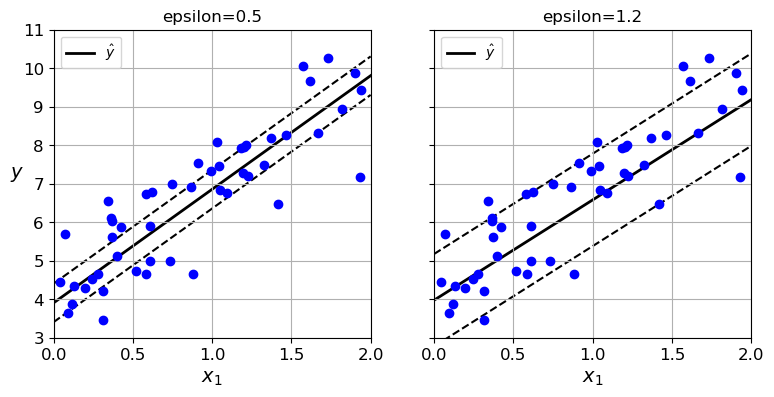

In [44]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    epsilon = svm_reg[-1].epsilon
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$", zorder=-2)
    plt.plot(x1s, y_pred + epsilon, "k--", zorder=-2)
    plt.plot(x1s, y_pred - epsilon, "k--", zorder=-2)
    plt.plot(X, y, "bo")
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis(axes)
    
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg1[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(f"epsilon={svm_reg2[-1].epsilon}")
plt.grid()


- For nonlinear regression, we can use kernelized SVM regression.

- The SVR class can be used to perform kernel SVM regression. This is the regression equivalent of the SVC class

- The LinearSVR class scales linearly with the size of the training set (like the LinearSVC class), while the SVR class becomes slow when the training set grows large (like the SVC class).

- Consider the quadratic model $y_n = 0.2+0.1x_n+0.5x^2_n+\varepsilon_n$, where the the iid noise is $\varepsilon_n\sim \mathcal{N}(0,\tfrac{1}{100})$.

In [45]:
np.random.seed(42)
n = 100
X = 2 * np.random.rand(n, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(n, 1)/10).ravel()

- We use the `LinearSVR` class using a degree 2 polynomial to fit this model.

- As usual, the hyperparameter `C` control the amount of regularization. We use `C=0.001` (more regularization) and `C=100` (less regularization).

In [46]:
from sklearn.svm import SVR
svm_poly_reg1 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1))
svm_poly_reg2 = make_pipeline(StandardScaler(),
                             SVR(kernel="poly", degree=2, C=100))
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=100, degree=2, kernel='poly'))])

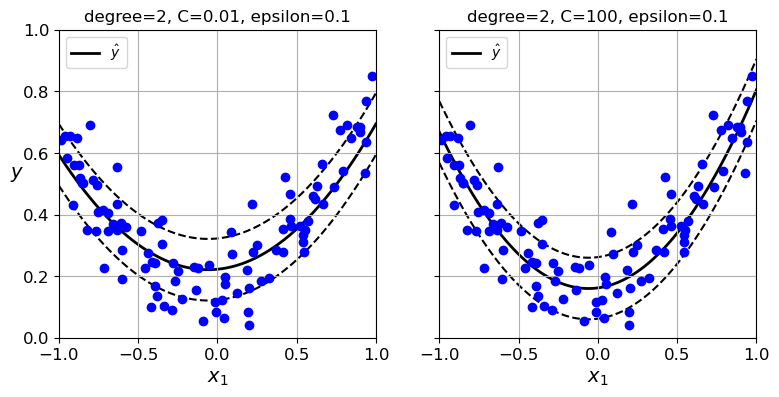

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg1[-1].degree}, "
          f"C={svm_poly_reg1[-1].C}, "
          f"epsilon={svm_poly_reg1[-1].epsilon}")
plt.ylabel("$y$", rotation=0)
plt.grid()

plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(f"degree={svm_poly_reg2[-1].degree}, "
          f"C={svm_poly_reg2[-1].C}, "
          f"epsilon={svm_poly_reg2[-1].epsilon}")
plt.grid()
plt.show()